# Utilities

In [1259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
import matplotlib.lines as mlines
import optuna
import os
import pywt


optuna.logging.set_verbosity(optuna.logging.WARNING)

In [1867]:
def read_files(filenames: list):
    """
    Read a list of files and return a single dataframe
    
    Parameters:
    -----------
    filenames : list
        List of filenames to read
    
    Returns:
    --------
    pd.DataFrame
    """
    return pd.concat([pd.read_csv(f'./data/{filename}') for filename in filenames])


def read_all_files():
    """
    Read all files in the data directory and return a single dataframe
    
    Returns:
    --------
    pd.DataFrame
    """

    dir = os.listdir('./data/')

    filenames = [filename for filename in dir if filename.endswith('.csv')]
    
    return read_files(filenames)

def categorize_port(port):
    if port in [80, 443, 444, 8080, 8443]:  # Common web ports
        return 'web'
    elif port in [21, 20]:  # FTP
        return 'ftp'
    elif port in [22]:
        return 'ssh'
    elif port in [23]:
        return 'telnet'
    elif port in [53]:  # DNS
        return 'dns'
    elif port in range(10, 1024):  # Well-known ports
        return 'well_known'
    elif port in range(1024, 49151):  # Registered ports
        return 'registered'
    elif port >= 49152:  # Dynamic/private ports
        return 'dynamic'
    else:
        return 'unknown'  # Other/unknown ports

In [ ]:
class Data:
    """
    Data class handles the dataset operations
    """
    def __init__(self, df, prepare_index = False):
        if prepare_index:
            df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed')
            df = df.set_index('timestamp')
            df = df.sort_index()
        
        self.df = df

    def assign(self, **kwargs):
        return Data(self.df.assign(**kwargs))
    
    def benign(self):
        return self.with_label('Benign')

    def with_label(self, label):
        return Data(self.df[self.df['label'] == label])
    
    def with_date(self, date):
        return Data(self.df.loc[date])
    
    def internal_dst(self):
        return Data(self.df[self.df['dst_ip'].str.contains('192.168')])
    
    def internal_src(self):
        return Data(self.df[self.df['src_ip'].str.contains('192.168')])
    
    def get_dummies(self, columns, dtype = int, drop_first = False):
        return Data(pd.get_dummies(self.df, columns = columns, dtype=dtype, drop_first=drop_first))
    
    def pca_numeric(self, n_components):
        X = self.df.select_dtypes(include=[np.number])
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_scaled)

        print(f'Explained variance: {np.sum(pca.explained_variance_ratio_):.2%}')
        # return Data(pd.DataFrame(X_pca, index = X.index, columns=[f'pca_{i}' for i in range(n_components)]))

        result_df = pd.DataFrame(X_pca, index = X.index, columns=[f'pca_{i}' for i in range(n_components)])
        label = self.df['label']
        return Data(pd.concat([result_df, label], axis=1))
    
    def resample(self, resampler):
        return Data(resampler.resample(self))
    
    def X_y(self, y_column):
        return self.df.drop(columns = y_column), self.df[y_column]
    
    def show(self):
        display(self.df)

class Resampler:
    """
    Handles resampling of the data
    """
    def __init__(self, agg, interval = '1s', interpolate = 'zero'):
        self.agg = agg
        self.interval = interval
        self.interpolate = interpolate
    
    def resample(self, data):
        return data.df.resample(self.interval).agg(self.agg).interpolate(self.interpolate).fillna(0)

def plot_predictions(y_true, y_pred, swt_df, hlinewidth = 0.3, hlinealpha = 0.3):
    """
    Plot the predictions on the SWT coefficients data

    Args:
    -----
    y_true : pd.Series
        True labels
    y_pred : pd.Series
        Predicted labels
    swt_df : pd.DataFrame
        SWT coefficients data
    hlinewidth : float
        Horizontal line width
    hlinealpha : float
        Horizontal line alpha
    """
    fig, ax = plt.subplots(figsize=(20, 10))
    
    for col in swt_df.columns:
        ax.plot(swt_df.index, swt_df[col], label=col)
    
    for i in swt_df[y_pred == -1].index:
        if i not in y_true[y_true == -1].index:
            ax.axvline(i, 0, 1, color='y', linestyle='dashed', linewidth=hlinewidth, alpha=hlinealpha)
        else:
            ax.axvline(i, 0, 1, color='g', linestyle='dashed', linewidth=hlinewidth, alpha=hlinealpha)
    
    for i in y_true[y_true == -1].index:
        if i not in swt_df[y_pred == -1].index:
            ax.axvline(i, 0, 1, color='r', linestyle='dashed', linewidth=hlinewidth, alpha=hlinealpha)
    
    legend1 = ax.legend(loc='upper left', title="Columns")
    ax.add_artist(legend1) 
    
    yellow_line = mlines.Line2D([], [], color='y', linestyle='dashed', linewidth=1,
                                  label='Yellow: Predicted anomaly only')
    green_line = mlines.Line2D([], [], color='g', linestyle='dashed', linewidth=1,
                                 label='Green: Predicted & True anomaly')
    red_line = mlines.Line2D([], [], color='r', linestyle='dashed', linewidth=1,
                               label='Red: True anomaly only')
    
    legend2 = ax.legend(handles=[yellow_line, green_line, red_line],
                        loc='upper left', bbox_to_anchor=(0, 0.15), title="Predictions")
    
    ax.set_title("Predictions displayed on the SWT coefficients data")
    ax.set_xlabel("Time (sec)")
    ax.set_ylabel("SWT Coefficients")
    plt.show()


In [2382]:
import numpy as np

class SWT2D:
    def __init__(self, wavelet, level=1, normalize=True, debug=False):
        self.normalize = normalize
        self.level = level
        
        wavelet = np.asarray(wavelet, dtype=float)
        self.wavelet = wavelet
        self.debug = debug

    def upsample_filter(self, filter_kernel, dilation):
        m, n = filter_kernel.shape
        new_m = (m - 1) * dilation + 1
        new_n = (n - 1) * dilation + 1

        upsampled = np.zeros((new_m, new_n), dtype=filter_kernel.dtype)
        upsampled[::dilation, ::dilation] = filter_kernel

        if self.debug:
            print(f'Upsampled filter kernel with dilation {dilation}:\n{upsampled}')

        return upsampled

    def convolve(self, data, wavelet):
        wavelet = np.flipud(np.fliplr(wavelet))
        kh, kw = wavelet.shape

        pad_h = kh // 2
        pad_w = kw // 2 
        
        padded = np.pad(data, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')

        if self.debug:
            print(f"Padded data:\n{padded}")

        out = np.zeros_like(data, dtype=float)
        for i in range(kh):
            for j in range(kw):
                out += wavelet[i, j] * padded[i:i + data.shape[0], j:j + data.shape[1]]
        return out

    def compute_norm(self, kernel, is_wavelet=True):
        center = (kernel.shape[0] // 2, kernel.shape[1] // 2)

        if is_wavelet:
            delta = np.zeros_like(kernel)
            delta[center] = 1.0
            effective = delta - kernel
        else:
            effective = kernel
        
        return np.sqrt(np.sum(effective ** 2))


    def transform(self, data):
        data = np.asarray(data, dtype=float)
        coeffs = []
        c = data.copy()
        
        for j in range(1, self.level + 1):
            dilation = 2 ** (j - 1)
            upsampled_wavelet = self.upsample_filter(self.wavelet, dilation)
            c_next = self.convolve(c, upsampled_wavelet)

            if self.debug:
                print(f'Convolved data with wavelet at level {j}:\n{c_next}')

            w = c - c_next

            if self.debug:
                print(f"Wavelet coefficients at level {j}:\n{w}")
                print(f"Approximation coefficients at level {j}:\n{c_next}")

            if self.normalize:
                norm_factor = self.compute_norm(upsampled_wavelet, is_wavelet=True)
                if norm_factor != 0:
                    w /= norm_factor
            coeffs.append(w)
            c = c_next
        
        approx = c
        if self.normalize:
            dilation = 2 ** (self.level - 1)
            upsampled_wavelet = self.upsample_filter(self.wavelet, dilation)
            norm_factor = self.compute_norm(upsampled_wavelet, is_wavelet=False)
            if norm_factor != 0:
                approx /= norm_factor
        
        return coeffs, approx

wvlet = pywt.Wavelet('haar')

SWT2D(wavelet=(wvlet.dec_lo, wvlet.dec_hi), level=2, debug=True).transform(np.array([[1, 1, 5, 2, 1, 1, 1], [1, 2, 8, 2, 1, 1, 1]]).T)

Upsampled filter kernel with dilation 1:
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
Padded data:
[[2. 1. 2. 1.]
 [1. 1. 1. 1.]
 [2. 1. 2. 1.]
 [8. 5. 8. 5.]
 [2. 2. 2. 2.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
Convolved data with wavelet at level 1:
[[2.12132034 0.70710678]
 [2.12132034 2.12132034]
 [9.89949494 8.48528137]
 [4.94974747 0.70710678]
 [1.41421356 1.41421356]
 [1.41421356 1.41421356]
 [1.41421356 1.41421356]]
Wavelet coefficients at level 1:
[[-1.12132034  0.29289322]
 [-1.12132034 -0.12132034]
 [-4.89949494 -0.48528137]
 [-2.94974747  1.29289322]
 [-0.41421356 -0.41421356]
 [-0.41421356 -0.41421356]
 [-0.41421356 -0.41421356]]
Approximation coefficients at level 1:
[[2.12132034 0.70710678]
 [2.12132034 2.12132034]
 [9.89949494 8.48528137]
 [4.94974747 0.70710678]
 [1.41421356 1.41421356]
 [1.41421356 1.41421356]
 [1.41421356 1.41421356]]
Upsampled filter kernel with dilation 2:
[[ 0.70710678  0.          0.70710678]
 [ 0.          0.    

([array([[-0.89044552,  0.23258782],
         [-0.89044552, -0.09634103],
         [-3.89071092, -0.38536412],
         [-2.3424077 ,  1.02669231],
         [-0.32892885, -0.32892885],
         [-0.32892885, -0.32892885],
         [-0.32892885, -0.32892885]]),
  array([[-0.50730594, -1.32380252],
         [-5.70345836, -6.8581589 ],
         [ 5.1381258 ,  0.8575276 ],
         [ 1.70303749, -0.74645225],
         [-0.33820396, -0.33820396],
         [-0.33820396, -0.33820396],
         [-0.33820396, -0.33820396]])],
 array([[2.12132034, 2.12132034],
        [8.48528137, 9.89949494],
        [0.70710678, 4.94974747],
        [1.41421356, 1.41421356],
        [1.41421356, 1.41421356],
        [1.41421356, 1.41421356],
        [1.41421356, 1.41421356]]))

# Load the data

In [1624]:
df = read_all_files()

# Intrusion Detection

## Preprocess the data

In [2346]:
TRAIN_DAY = '2017-07-03'
TEST_DAY = '2017-07-07'

In [2347]:
data = Data(df, prepare_index=True)

In [2348]:
internal = data.internal_dst().assign(
    dst_host_port = lambda x: x['dst_ip'] + ":" + x['dst_port'].astype(str),
    dst_port_category=lambda x: x['dst_port'].apply(categorize_port),
    src_port_category=lambda x: x['src_port'].apply(categorize_port),
    ssh_duration = lambda x: x['duration'].where((x['dst_port'] == 22) & (~x['src_ip'].str.contains('192.168')), 0),
    ftp_duration = lambda x: x['duration'].where((x['dst_port'] == 21) & (~x['src_ip'].str.contains('192.168')), 0),
).get_dummies(['dst_port_category', 'src_port_category'])
internal.show()


flow_id  \
timestamp                                                                       
2017-07-03 07:55:58.598308  8.254.250.126_80_192.168.10.5_49188_TCP_2017-0...   
2017-07-03 07:56:22.331018  8.253.185.121_80_192.168.10.14_49486_TCP_2017-...   
2017-07-03 07:56:37.897192  192.168.10.9_137_192.168.10.3_137_UDP_2017-07-...   
2017-07-03 07:56:37.908429  192.168.10.9_63683_192.168.10.3_53_UDP_2017-07...   
2017-07-03 07:56:37.908639  192.168.10.9_63276_192.168.10.3_53_UDP_2017-07...   
...                                                                       ...   
2017-07-07 16:02:38.913542  192.168.10.8_123_192.168.10.3_123_UDP_2017-07-...   
2017-07-07 16:02:39.565876  192.168.10.50_22_192.168.10.17_37758_TCP_2017-...   
2017-07-07 16:02:39.567285  192.168.10.17_37759_192.168.10.50_22_TCP_2017-...   
2017-07-07 16:02:40.805791  192.168.10.50_22_192.168.10.17_37759_TCP_2017-...   
2017-07-07 16:02:41.005391  23.10.108.151_443_192.168.10.14_59111_TCP_2017...   

                                   src_ip  src_port         dst_ip  dst_port  \
timestamp                                                                      
2017-07-03 07:55:58.598308  8.254.250.126        80   192.168.10.5     49188   
2017-07-03 07:56:22.331018  8.253.185.121        80  192.168.10.14     49486   
2017-07-03 07:56:37.897192   192.168.10.9       137   192.168.10.3       137   
2017-07-03 07:56:37.908429   192.168.10.9     63683   192.168.10.3        53   
2017-07-03 07:56:37.908639   192.168.10.9     63276   192.168.10.3        53   
...                                   ...       ...            ...       ...   
2017-07-07 16:02:38.913542   192.168.10.8       123   192.168.10.3       123   
2017-07-07 16:02:39.565876  192.168.10.50        22  192.168.10.17     37758   
2017-07-07 16:02:39.567285  192.168.10.17     37759  192.168.10.50        22   
2017-07-07 16:02:40.805791  192.168.10.50        22  192.168.10.17     37759   
2017-07-07 16:02:41.005391  23.10.108.151       443  192.168.10.14     59111   

                           protocol   duration  packets_count  \
timestamp                                                       
2017-07-03 07:55:58.598308      TCP   0.000010              8   
2017-07-03 07:56:22.331018      TCP   0.000010              9   
2017-07-03 07:56:37.897192      UDP  83.068408             80   
2017-07-03 07:56:37.908429      UDP   0.000292              4   
2017-07-03 07:56:37.908639      UDP   0.000293              4   
...                             ...        ...            ...   
2017-07-07 16:02:38.913542      UDP   0.000125              4   
2017-07-07 16:02:39.565876      TCP   0.000085              3   
2017-07-07 16:02:39.567285      TCP   1.238502             85   
2017-07-07 16:02:40.805791      TCP   0.000081              3   
2017-07-07 16:02:41.005391      TCP   0.000000              1   

                            fwd_packets_count  bwd_packets_count  ...  \
timestamp                                                         ...   
2017-07-03 07:55:58.598308                  8                  0  ...   
2017-07-03 07:56:22.331018                  9                  0  ...   
2017-07-03 07:56:37.897192                 38                 42  ...   
2017-07-03 07:56:37.908429                  2                  2  ...   
2017-07-03 07:56:37.908639                  2                  2  ...   
...                                       ...                ...  ...   
2017-07-07 16:02:38.913542                  2                  2  ...   
2017-07-07 16:02:39.565876                  0                  3  ...   
2017-07-07 16:02:39.567285                 42                 43  ...   
2017-07-07 16:02:40.805791                  0                  3  ...   
2017-07-07 16:02:41.005391                  0                  1  ...   

                            dst_port_category_web  \
timestamp                                           
2017-07-03 07:55:58.598308                      0   
2017-07-03 07:56:22.

In [2349]:
resampler = Resampler({
    "duration": "mean",
    "payload_bytes_std": lambda x: np.log(1 / (np.mean(x) + 1)),
    "dst_port_category_web": "sum",
    "rst_flag_counts": "sum",
    "dst_host_port": "nunique",
    "dst_port_category_ftp": "sum",
    "dst_port_category_ssh": "sum",
    "label": lambda x: 1 if x.eq("Benign").all() else -1
}, '1s')

monday = internal.with_date(TRAIN_DAY).with_label('Benign').resample(resampler)
friday = internal.with_date(TEST_DAY).resample(resampler)

monday.show()
friday.show()

duration  payload_bytes_std  dst_port_category_web  \
timestamp                                                                 
2017-07-03 07:55:58  0.000010           0.000000                      0   
2017-07-03 07:55:59  0.000010           0.000000                      0   
2017-07-03 07:56:00  0.000010           0.000000                      0   
2017-07-03 07:56:01  0.000010           0.000000                      0   
2017-07-03 07:56:02  0.000010           0.000000                      0   
...                       ...                ...                    ...   
2017-07-03 16:01:30  0.000000           0.000000                      0   
2017-07-03 16:01:31  0.000000           0.000000                      0   
2017-07-03 16:01:32  0.000000           0.000000                      0   
2017-07-03 16:01:33  0.000000           0.000000                      0   
2017-07-03 16:01:34  0.059246          -3.367296                      0   

                     rst_flag_counts  dst_host_port  dst_port_category_ftp  \
timestamp                                                                    
2017-07-03 07:55:58                0              1                      0   
2017-07-03 07:55:59                0              0                      0   
2017-07-03 07:56:00                0              0                      0   
2017-07-03 07:56:01                0              0                      0   
2017-07-03 07:56:02                0              0                      0   
...                              ...            ...                    ...   
2017-07-03 16:01:30                0              3                      0   
2017-07-03 16:01:31                0              0                      0   
2017-07-03 16:01:32                0              0                      0   
2017-07-03 16:01:33                0              0                      0   
2017-07-03 16:01:34                1              3                      0   

                     dst_port_category_ssh  label  
timestamp                                          
2017-07-03 07:55:58                      0      1  
2017-07-03 07:55:59                      0      1  
2017-07-03 07:56:00                      0      1  
2017-07-03 07:56:01                      0      1  
2017-07-03 07:56:02                      0      1  
...                                    ...    ...  
2017-07-03 16:01:30                      0      1  
2017-07-03 16:01:31                      0      1  
2017-07-03 16:01:32                      0      1  
2017-07-03 16:01:33                      0      1  
2017-07-03 16:01:34                      0      1  

[29137 rows x 8 columns]

duration  payload_bytes_std  dst_port_category_web  \
timestamp                                                                   
2017-07-07 07:59:50  712.908845          -5.188826                      0   
2017-07-07 07:59:51  712.908845          -5.188826                      0   
2017-07-07 07:59:52  712.908845          -5.188826                      0   
2017-07-07 07:59:53  712.908845          -5.188826                      0   
2017-07-07 07:59:54  712.908845          -5.188826                      0   
...                         ...                ...                    ...   
2017-07-07 16:02:37    0.000000           0.000000                      0   
2017-07-07 16:02:38    0.376721          -4.468137                      0   
2017-07-07 16:02:39    0.619293          -4.792003                      0   
2017-07-07 16:02:40    0.000081           0.000000                      0   
2017-07-07 16:02:41    0.000000           0.000000                      0   

                     rst_flag_counts  dst_host_port  dst_port_category_ftp  \
timestamp                                                                    
2017-07-07 07:59:50                2              2                      0   
2017-07-07 07:59:51                0              0                      0   
2017-07-07 07:59:52                0              0                      0   
2017-07-07 07:59:53                0              0                      0   
2017-07-07 07:59:54                0              0                      0   
...                              ...            ...                    ...   
2017-07-07 16:02:37                0              1                      0   
2017-07-07 16:02:38                0              4                      0   
2017-07-07 16:02:39                0              2                      0   
2017-07-07 16:02:40                0              1                      0   
2017-07-07 16:02:41                0              1                      0   

                     dst_port_category_ssh  label  
timestamp                                          
2017-07-07 07:59:50                      0      1  
2017-07-07 07:59:51                      0      1  
2017-07-07 07:59:52                      0      1  
2017-07-07 07:59:53                      0      1  
2017-07-07 07:59:54                      0      1  
...                                    ...    ...  
2017-07-07 16:02:37                      0      1  
2017-07-07 16:02:38                      1      1  
2017-07-07 16:02:39                      1      1  
2017-07-07 16:02:40                      0      1  
2017-07-07 16:02:41                      0      1  

[28972 rows x 8 columns]

<Axes: >

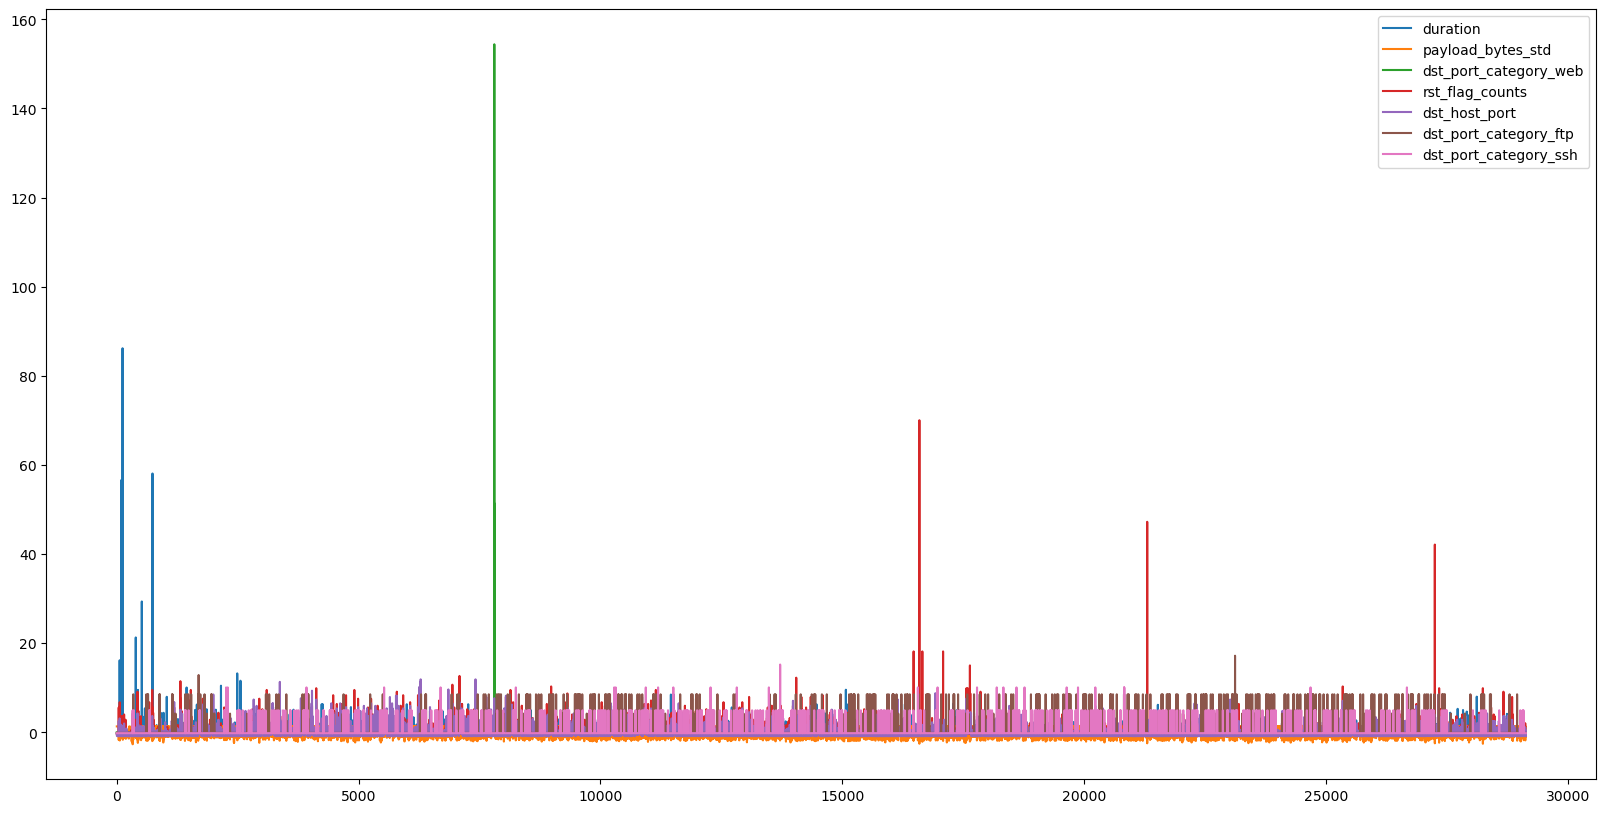

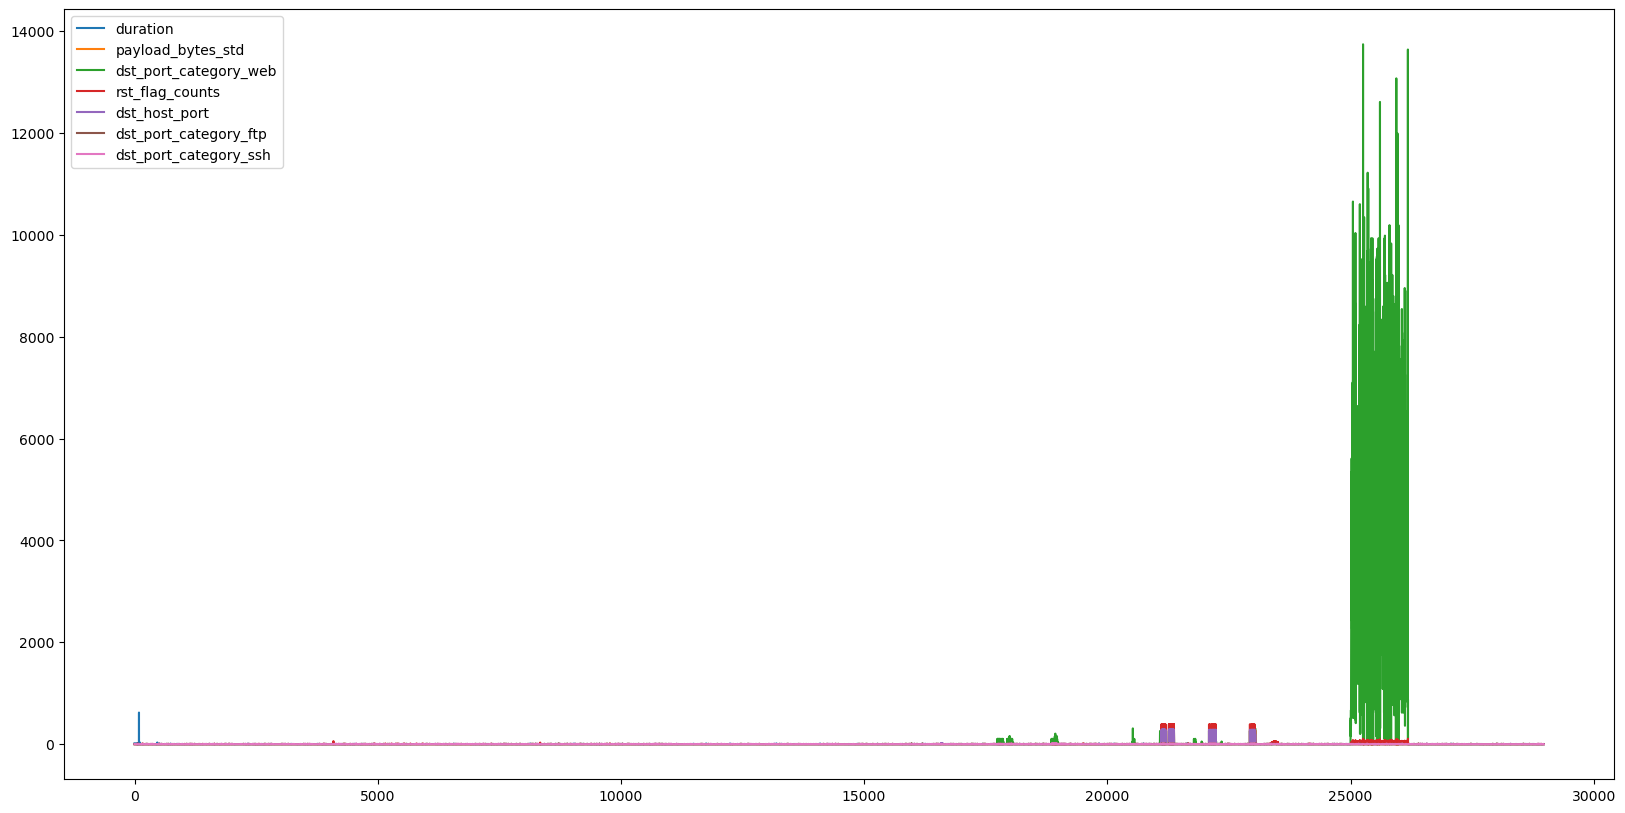

In [2350]:
X_monday, y_monday = monday.X_y('label')
X_friday, y_friday = friday.X_y('label')

scaler = StandardScaler()
X_monday = pd.DataFrame(scaler.fit_transform(X_monday), columns=X_monday.columns)
X_friday = pd.DataFrame(scaler.transform(X_friday), columns=X_friday.columns)

X_monday.plot(figsize=(20, 10))
X_friday.plot(figsize=(20, 10))

## Friday (Isolation Forest no SWT)

  0%|          | 0/100 [00:00<?, ?it/s]

Best Parameters: {'contamination': 0.006431009218745726}
Best score: 0.7906219472484532
              precision    recall  f1-score   support

     Anomaly       0.85      0.74      0.79      1641
      Normal       0.98      0.99      0.99     27331

    accuracy                           0.98     28972
   macro avg       0.92      0.87      0.89     28972
weighted avg       0.98      0.98      0.98     28972



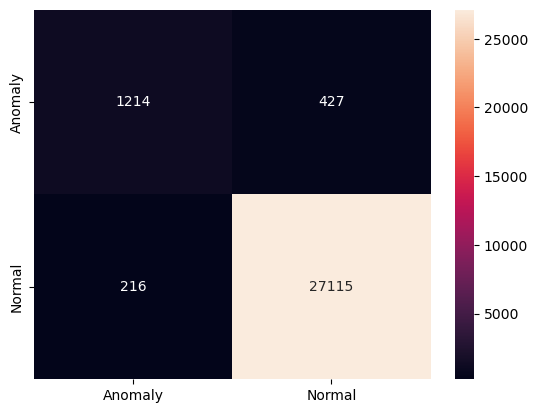

In [2351]:

y_true = y_friday.reset_index(drop=True)

def objective(trial):
    c = trial.suggest_float("contamination", 0.001, 0.2)

    clf = IsolationForest(contamination=c, bootstrap=True, random_state=3123)
    clf.fit(X_monday)

    y_pred = clf.predict(X_friday)

    return f1_score(y_true, y_pred, average="binary", pos_label=-1)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, n_jobs=8, show_progress_bar=True)

print("Best Parameters:", study.best_params)
print("Best score:", study.best_value)

clf_no_swt = IsolationForest(contamination=study.best_params['contamination'], bootstrap=True, random_state=3123)

clf_no_swt.fit(X_monday)

y_pred = clf_no_swt.predict(X_friday)

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', xticklabels=['Anomaly', 'Normal'], yticklabels=['Anomaly', 'Normal'])
print(classification_report(y_true, y_pred, target_names=['Anomaly', 'Normal']))

## Apply SWT


Choosing wavelet: https://www.mathworks.com/help/wavelet/gs/choose-a-wavelet.html

In [2352]:
WAVELET = 'db4'
LEVEL = 2

def swt_transform111(X, wavelet='haar', level=2):
    if X.shape[0] % 2 != 0:
        X = X.iloc[:-1]
    
    coefs = pywt.swt2(X, wavelet, level=level, trim_approx=True, norm=True)

    return pd.DataFrame(coefs[level][1], columns=X.columns + '_ad')


def swt_transform(X, wavelet_name='coif1', level=1):
    wavelet = pywt.Wavelet(wavelet_name)

    swt = SWT2D(wavelet=(wavelet.dec_lo, wavelet.dec_hi), level=level).transform(X.values)

    result = pd.DataFrame(swt[0][level - 1], columns=X.columns + f'_detail_{level - 1}')

    for level in range(0, level - 1):
        result = pd.concat([result, pd.DataFrame(swt[0][level], columns=X.columns + f'_detail_{level}')], axis=1)
    
    return result


def plot_coefs(coefs):
    plt.figure(figsize=(20, 10))
    plt.plot(coefs)
    plt.legend(coefs.columns)
    plt.show()

X_monday_swt = swt_transform(X_monday, WAVELET, LEVEL)
X_friday_swt = swt_transform(X_friday, WAVELET, LEVEL)

<Axes: >

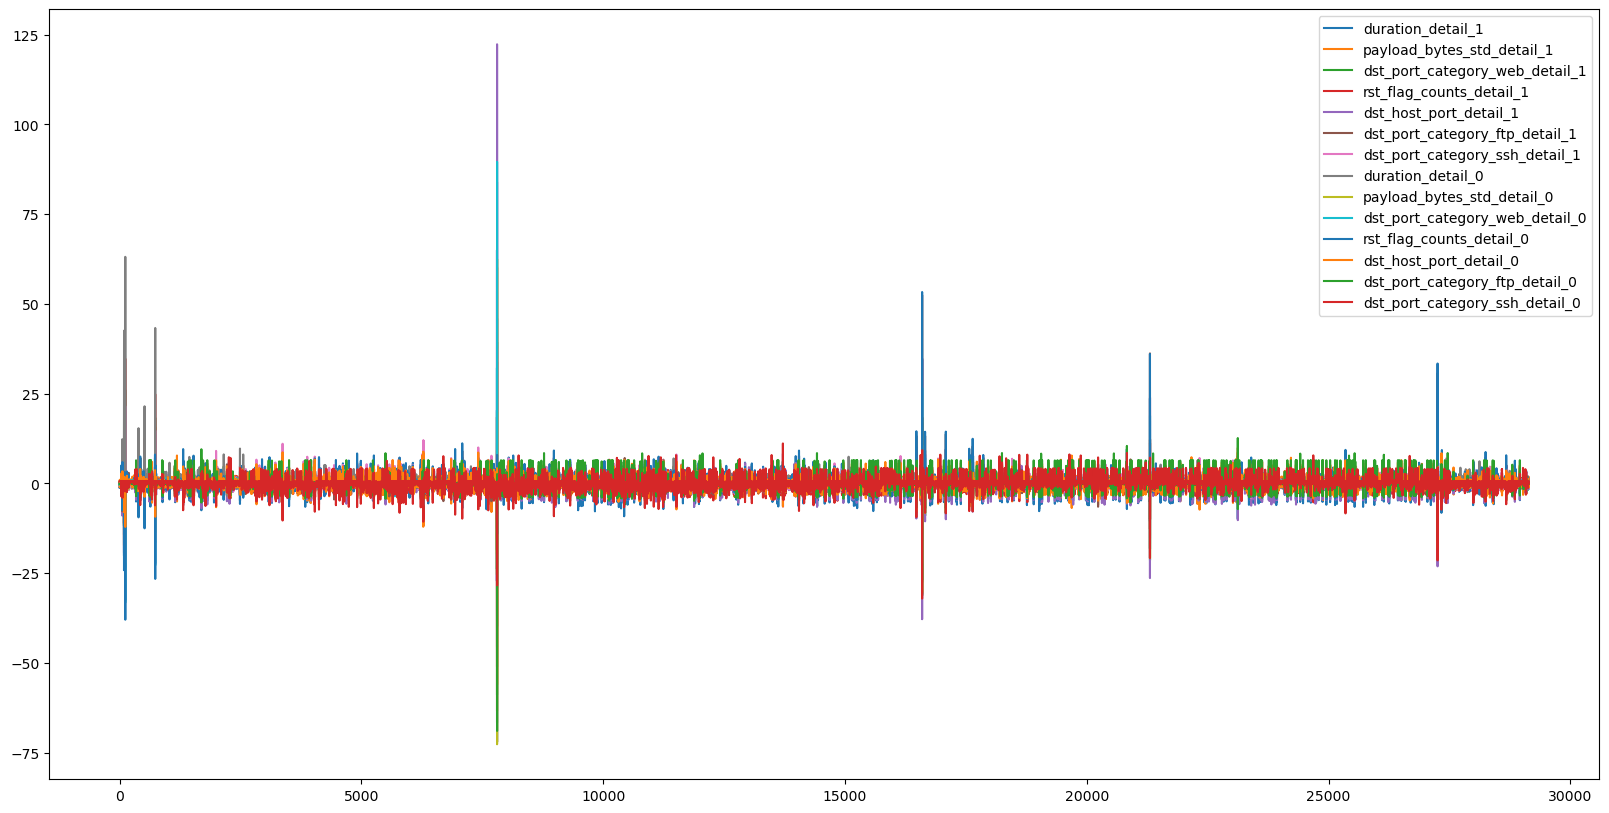

In [2353]:
X_monday_swt.plot(figsize=(20, 10))

<Axes: >

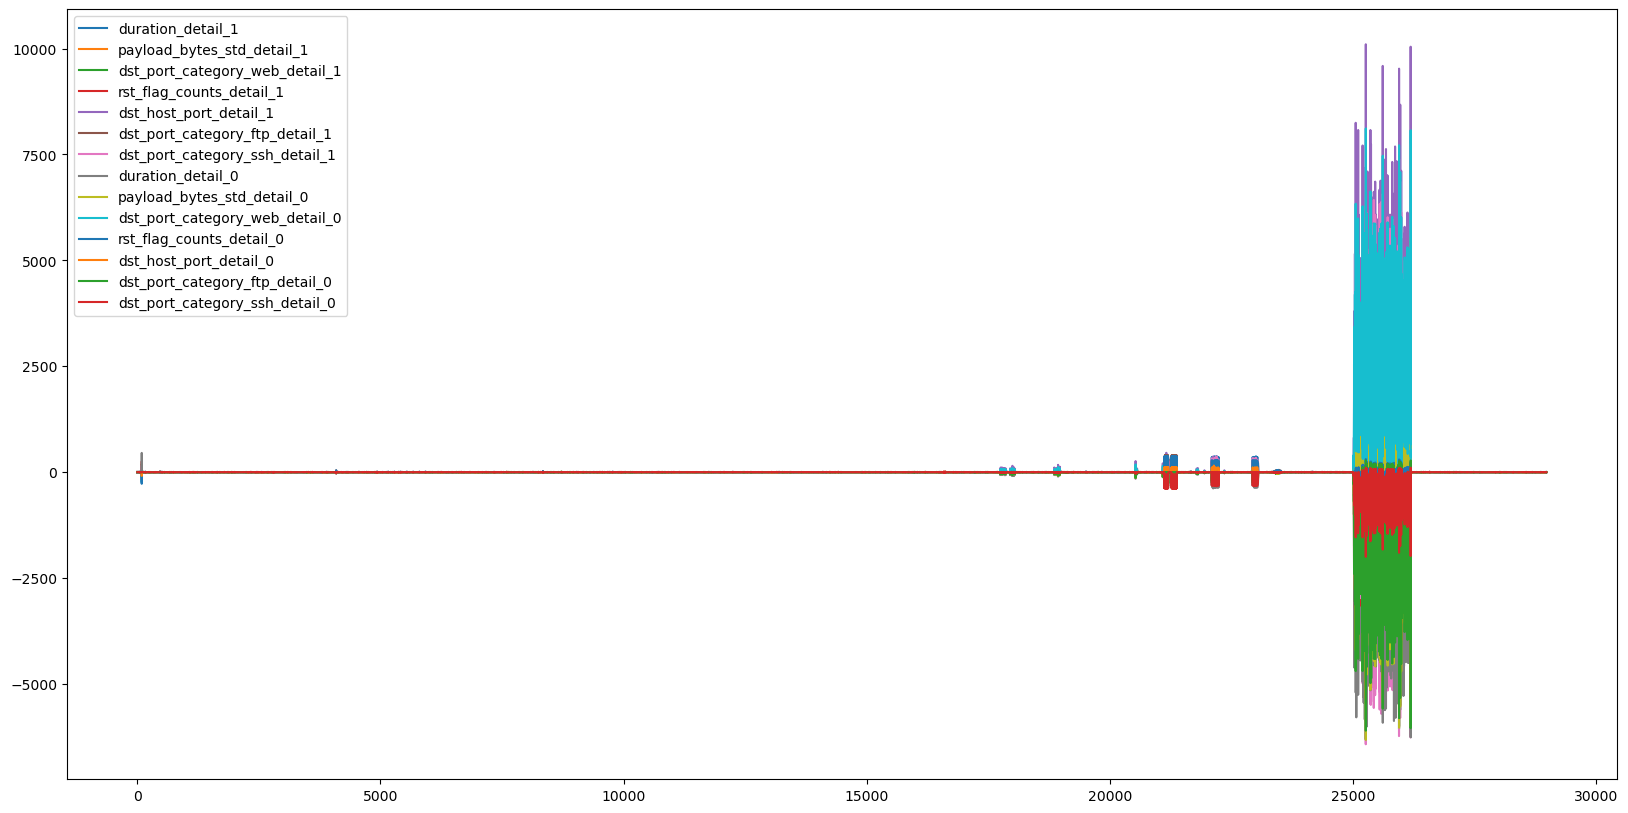

In [2354]:
X_friday_swt.plot(figsize=(20, 10))

## Friday (Isolation forest with SWT)

  0%|          | 0/100 [00:00<?, ?it/s]

Best Parameters: {'contamination': 0.0010355422733261117}
best score: 0.834380354083381
              precision    recall  f1-score   support

     Anomaly       0.79      0.89      0.83      1641
      Normal       0.99      0.99      0.99     27331

    accuracy                           0.98     28972
   macro avg       0.89      0.94      0.91     28972
weighted avg       0.98      0.98      0.98     28972



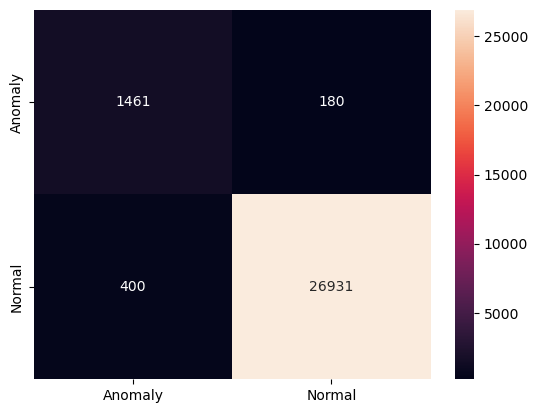

In [2355]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
import optuna

y_true = y_friday.reset_index(drop=True)

def objective(trial):
    c = trial.suggest_float("contamination", 0.001, 0.2)  # Contamination

    clf = IsolationForest(contamination=c, bootstrap=True, random_state=3123)
    clf.fit(X_monday_swt)

    y_pred = clf.predict(X_friday_swt)

    return f1_score(y_true, y_pred, average="binary", pos_label=-1)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, n_jobs=8, show_progress_bar=True)

print("Best Parameters:", study.best_params)
print("best score:", study.best_value)

clf = IsolationForest(contamination=study.best_params['contamination'], bootstrap=True, random_state=3123)

clf.fit(X_monday_swt)

y_pred = clf.predict(X_friday_swt)

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', xticklabels=['Anomaly', 'Normal'], yticklabels=['Anomaly', 'Normal'])
print(classification_report(y_true, y_pred, target_names=['Anomaly', 'Normal']))

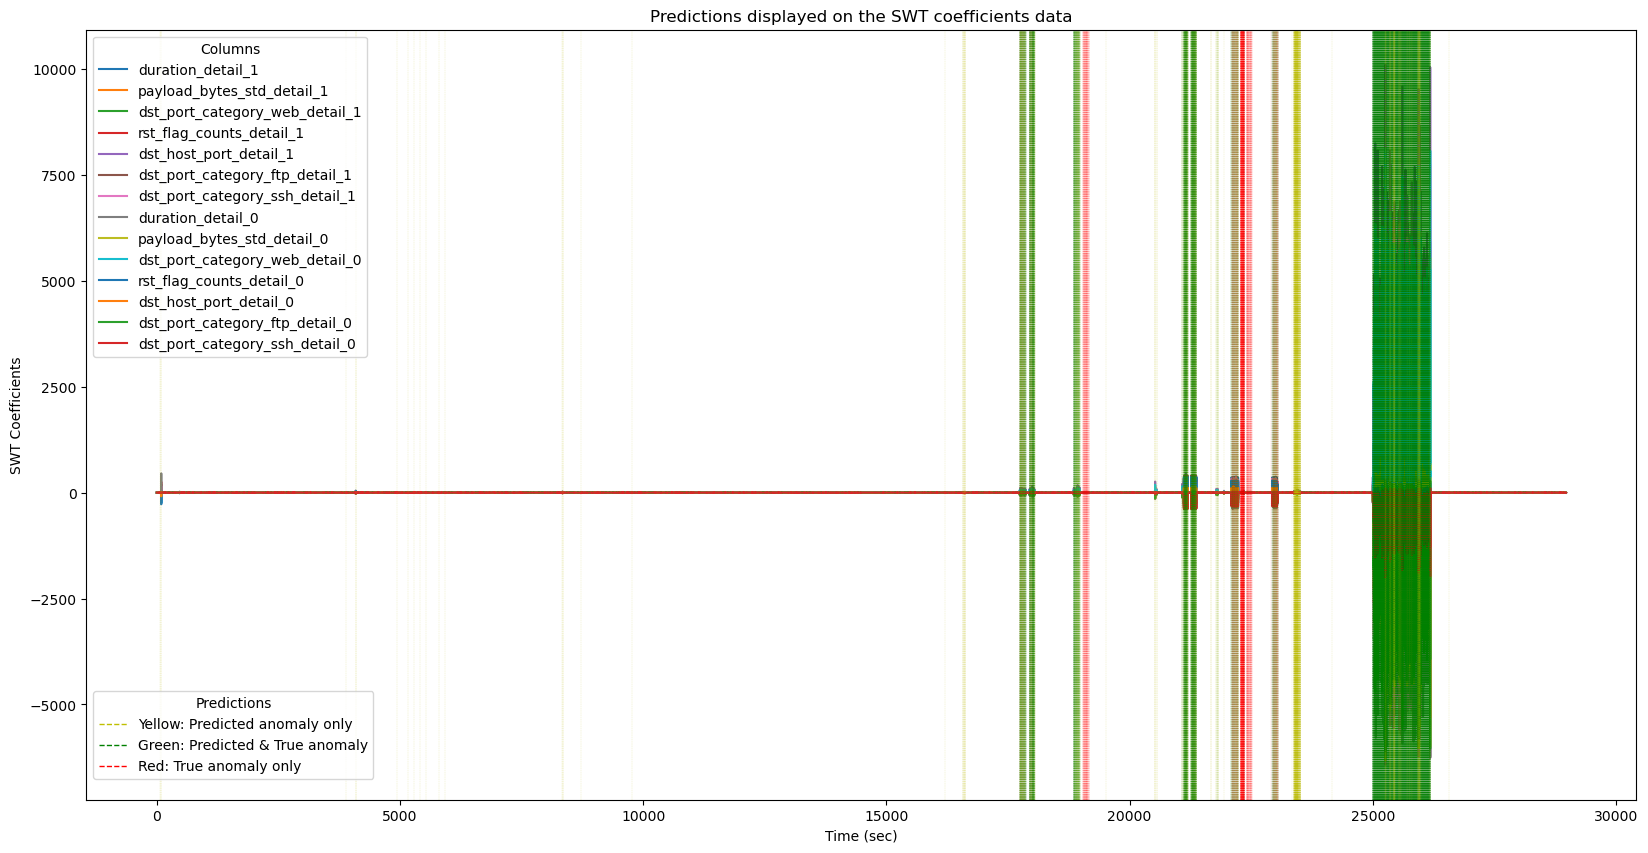

In [2356]:
plot_predictions(y_true, y_pred, X_friday_swt)

## Wednesday (Isolation Forest no SWT)

              precision    recall  f1-score   support

     Anomaly       0.72      0.13      0.22      2622
      Normal       0.92      1.00      0.96     27831

    accuracy                           0.92     30453
   macro avg       0.82      0.56      0.59     30453
weighted avg       0.91      0.92      0.89     30453



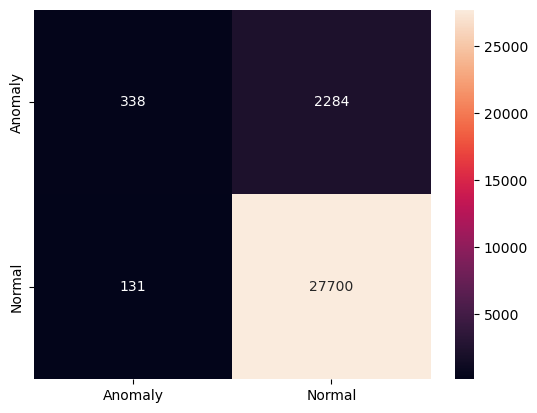

In [2357]:
wednesday = internal.with_date('2017-07-05').resample(resampler)

X_wednesday, y_wednesday = wednesday.X_y('label')

X_wednesday = pd.DataFrame(scaler.transform(X_wednesday), columns=X_wednesday.columns)

y_true = y_wednesday.reset_index(drop=True)

y_pred = clf_no_swt.predict(X_wednesday)

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', xticklabels=['Anomaly', 'Normal'], yticklabels=['Anomaly', 'Normal'])
print(classification_report(y_true, y_pred, target_names=['Anomaly', 'Normal']))

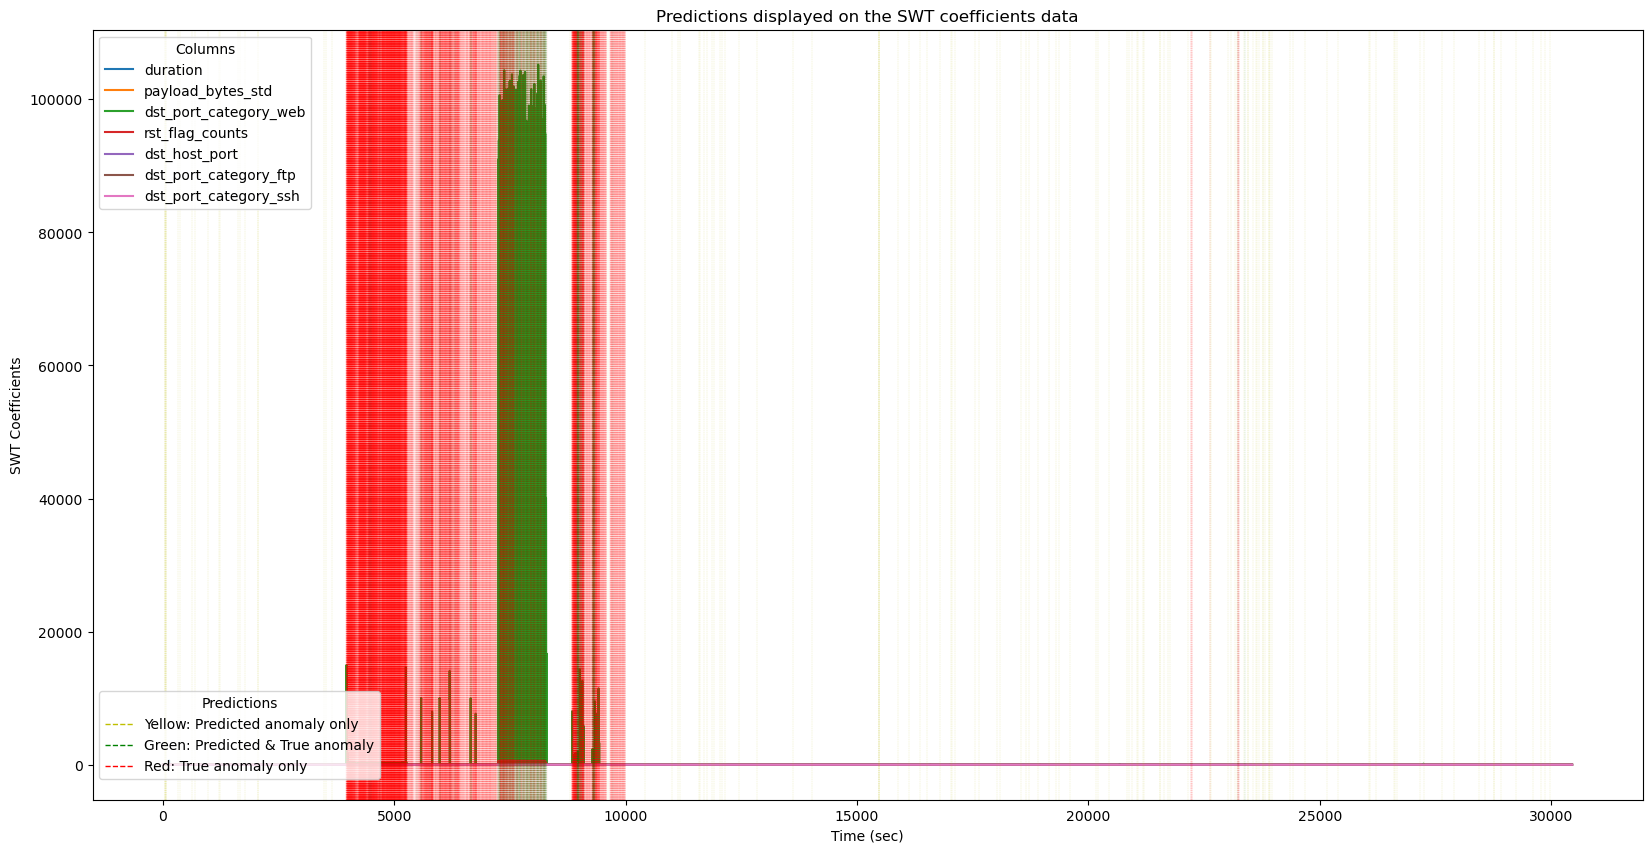

In [2358]:
plot_predictions(y_true, y_pred, X_wednesday)

## Wednesday (Isolation Forest with SWT)

              precision    recall  f1-score   support

     Anomaly       0.84      0.80      0.82      2622
      Normal       0.98      0.99      0.98     27831

    accuracy                           0.97     30453
   macro avg       0.91      0.89      0.90     30453
weighted avg       0.97      0.97      0.97     30453



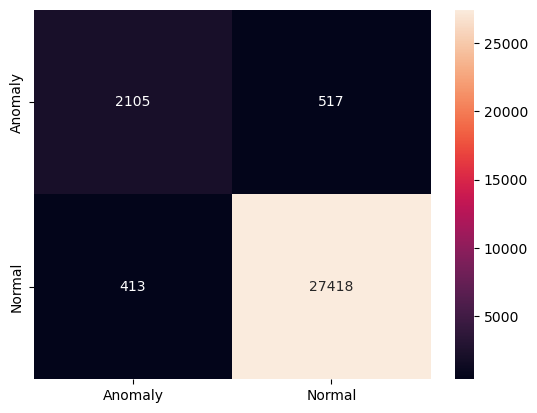

In [2359]:
X_wednesday_swt = swt_transform(X_wednesday, WAVELET, level=LEVEL)

y_true = y_wednesday.reset_index(drop=True)

y_pred = clf.predict(X_wednesday_swt)

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', xticklabels=['Anomaly', 'Normal'], yticklabels=['Anomaly', 'Normal'])
print(classification_report(y_true, y_pred, target_names=['Anomaly', 'Normal']))

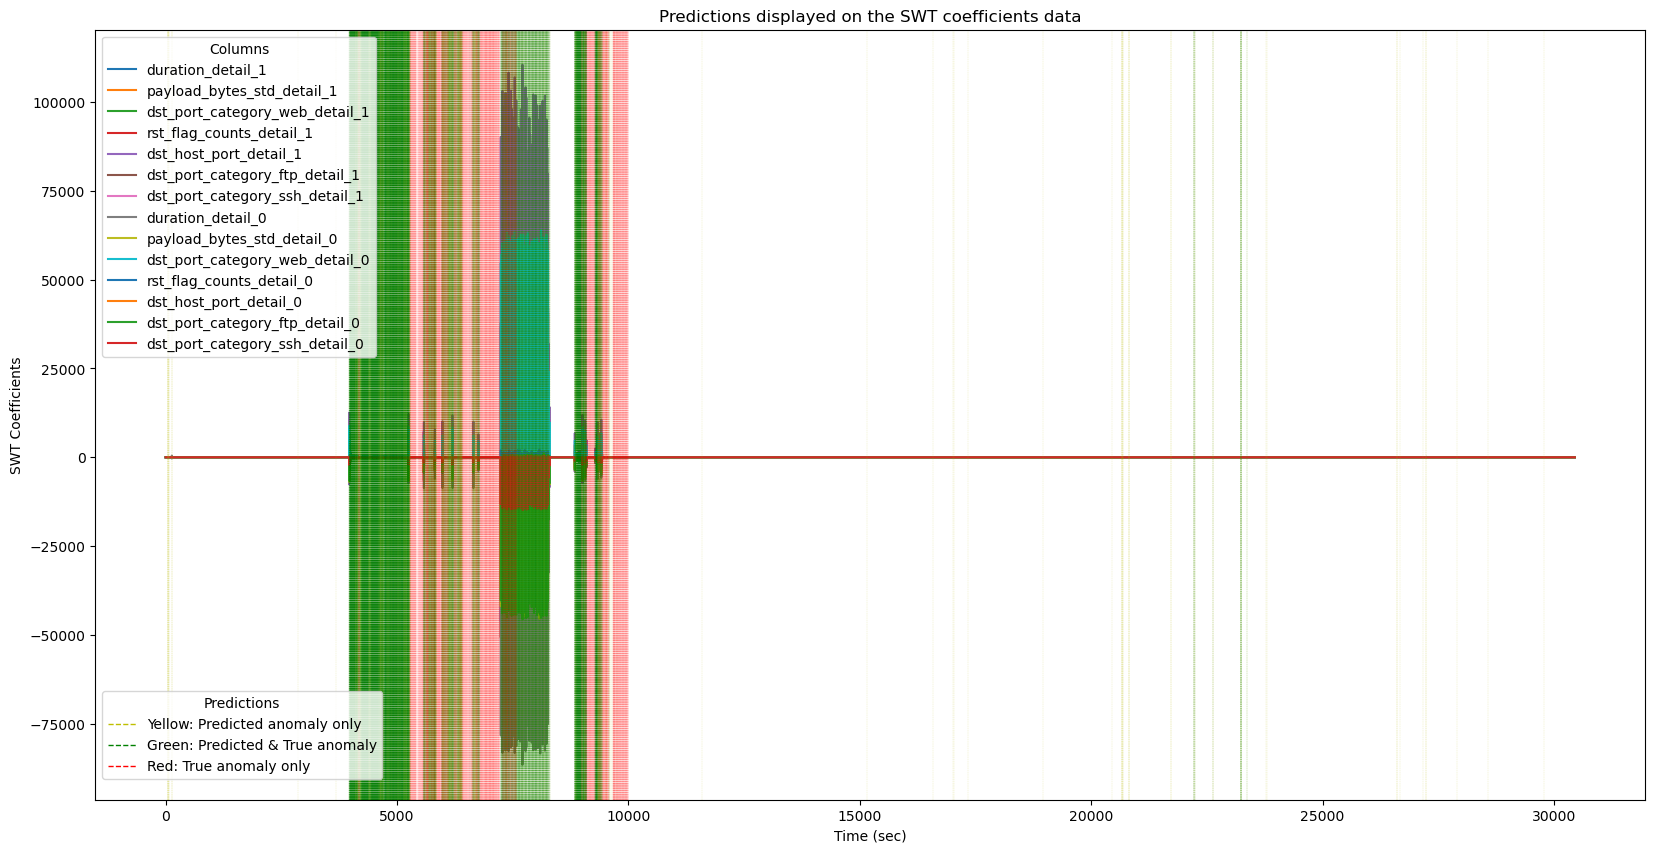

In [2360]:
plot_predictions(y_true, y_pred, X_wednesday_swt)

## Thursday (Isolation Forest without SWT)

              precision    recall  f1-score   support

     Anomaly       0.24      0.00      0.01      2682
      Normal       0.75      1.00      0.86      8178

    accuracy                           0.75     10860
   macro avg       0.50      0.50      0.43     10860
weighted avg       0.63      0.75      0.65     10860



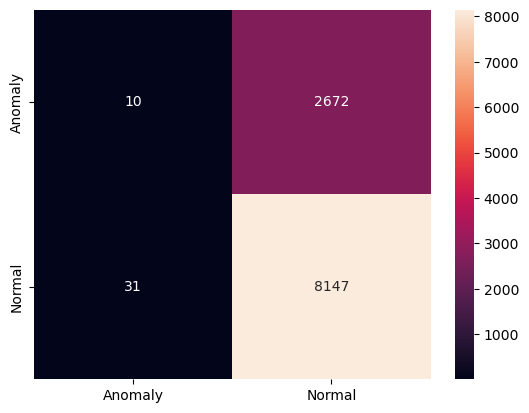

In [2361]:
thursday = internal.with_date('2017-07-06').resample(resampler)

X_tuesday, y_tuesday = thursday.X_y('label')

y_true = y_tuesday.reset_index(drop=True)

X_tuesday = pd.DataFrame(scaler.transform(X_tuesday), columns=X_tuesday.columns)

y_pred = clf_no_swt.predict(X_tuesday)

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', xticklabels=['Anomaly', 'Normal'], yticklabels=['Anomaly', 'Normal'])
print(classification_report(y_true, y_pred, target_names=['Anomaly', 'Normal']))

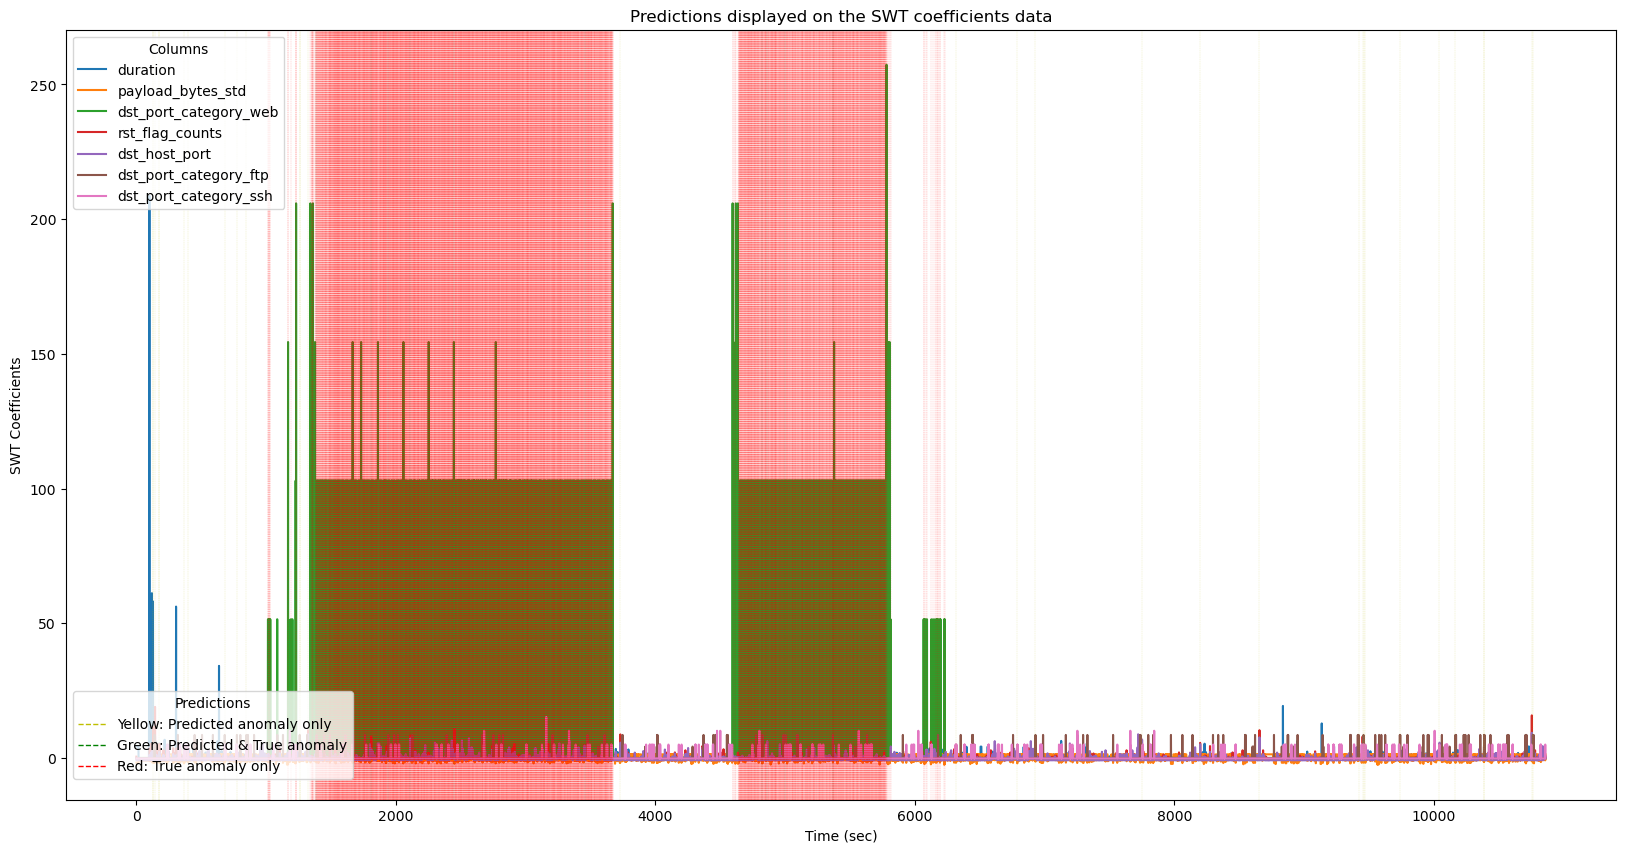

In [2362]:
plot_predictions(y_true, y_pred, X_tuesday)

## Thursday (Isolation Forest with SWT)

              precision    recall  f1-score   support

     Anomaly       0.81      0.99      0.89      2682
      Normal       1.00      0.93      0.96      8178

    accuracy                           0.94     10860
   macro avg       0.91      0.96      0.93     10860
weighted avg       0.95      0.94      0.94     10860



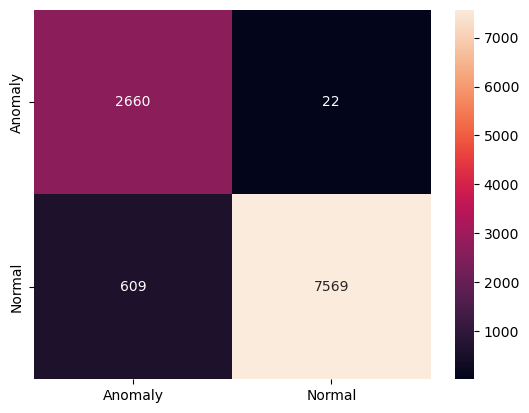

In [2363]:
X_thursday_swt = swt_transform(X_tuesday, WAVELET, level=LEVEL)

y_true = y_tuesday.reset_index(drop=True)

y_pred = clf.predict(X_thursday_swt)

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', xticklabels=['Anomaly', 'Normal'], yticklabels=['Anomaly', 'Normal'])
print(classification_report(y_true, y_pred, target_names=['Anomaly', 'Normal']))

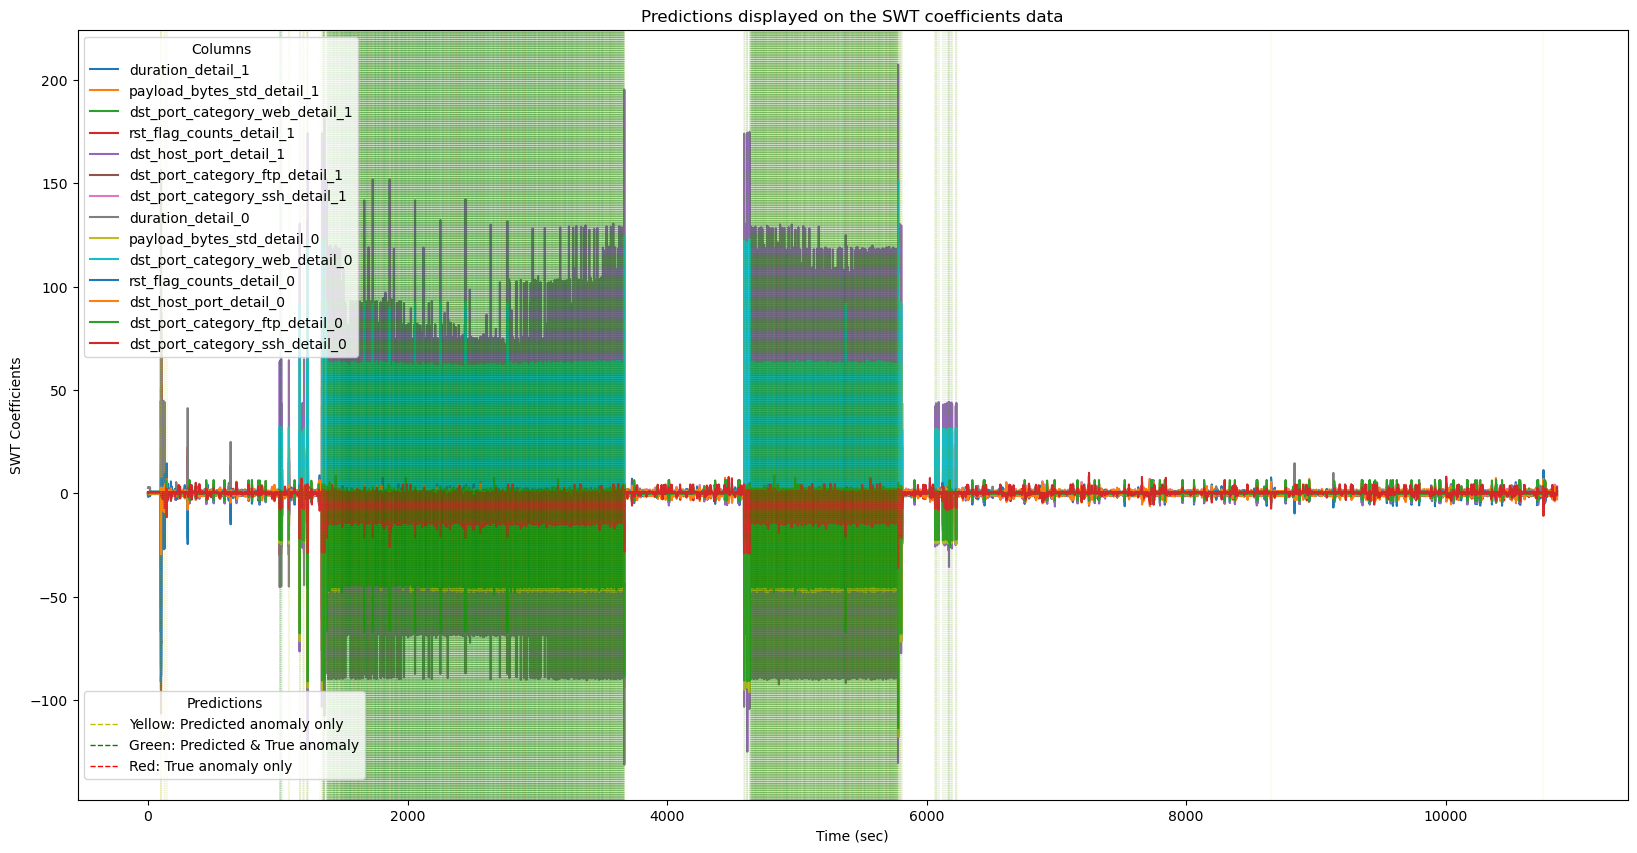

In [2364]:
plot_predictions(y_true, y_pred, X_thursday_swt)

## Tuesday (Isolation Forest without SWT)

              precision    recall  f1-score   support

     Anomaly       0.67      0.10      0.18      3406
      Normal       0.89      0.99      0.94     25801

    accuracy                           0.89     29207
   macro avg       0.78      0.55      0.56     29207
weighted avg       0.87      0.89      0.85     29207



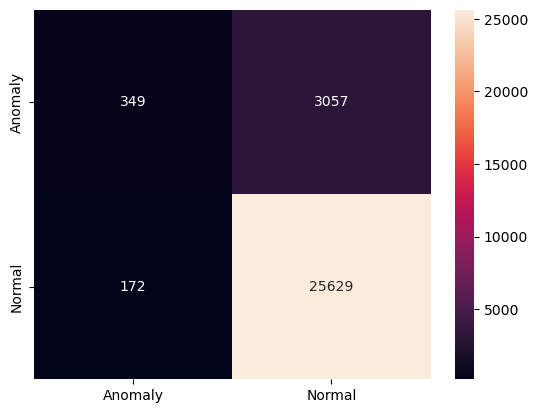

In [2365]:
tuesday = internal.with_date('2017-07-04').resample(resampler)

X_tuesday, y_tuesday = tuesday.X_y('label')

y_true = y_tuesday.reset_index(drop=True)

X_tuesday = pd.DataFrame(scaler.transform(X_tuesday), columns=X_tuesday.columns)

y_pred = clf_no_swt.predict(X_tuesday)

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', xticklabels=['Anomaly', 'Normal'], yticklabels=['Anomaly', 'Normal'])
print(classification_report(y_true, y_pred, target_names=['Anomaly', 'Normal']))

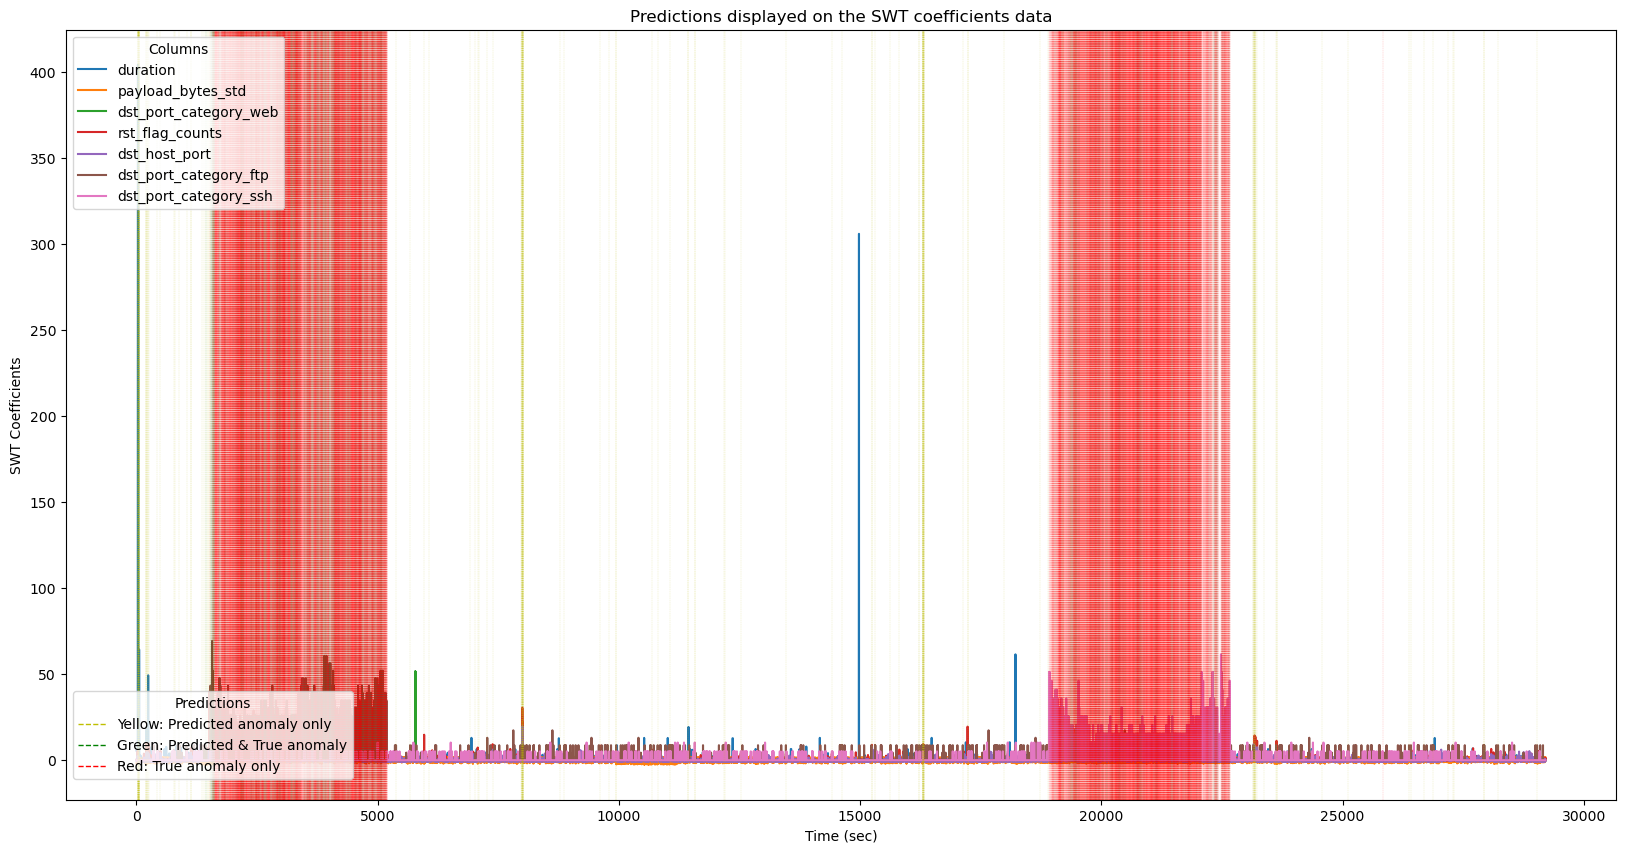

In [2366]:
plot_predictions(y_true, y_pred, X_tuesday)

## Tuesday (Isolation Forest with SWT)

              precision    recall  f1-score   support

     Anomaly       0.41      0.15      0.22      3406
      Normal       0.90      0.97      0.93     25801

    accuracy                           0.88     29207
   macro avg       0.65      0.56      0.58     29207
weighted avg       0.84      0.88      0.85     29207



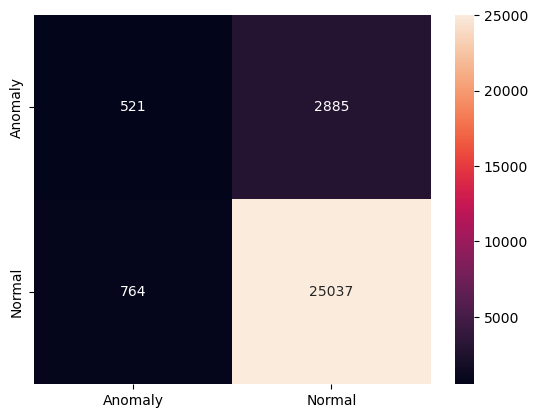

In [2367]:
X_tuesday_swt = swt_transform(X_tuesday, WAVELET, level=LEVEL)

y_true = y_tuesday.reset_index(drop=True)

y_pred = clf.predict(X_tuesday_swt)

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', xticklabels=['Anomaly', 'Normal'], yticklabels=['Anomaly', 'Normal'])
print(classification_report(y_true, y_pred, target_names=['Anomaly', 'Normal']))

### Unfortunate results for FTP-Patator and SSH-Patator

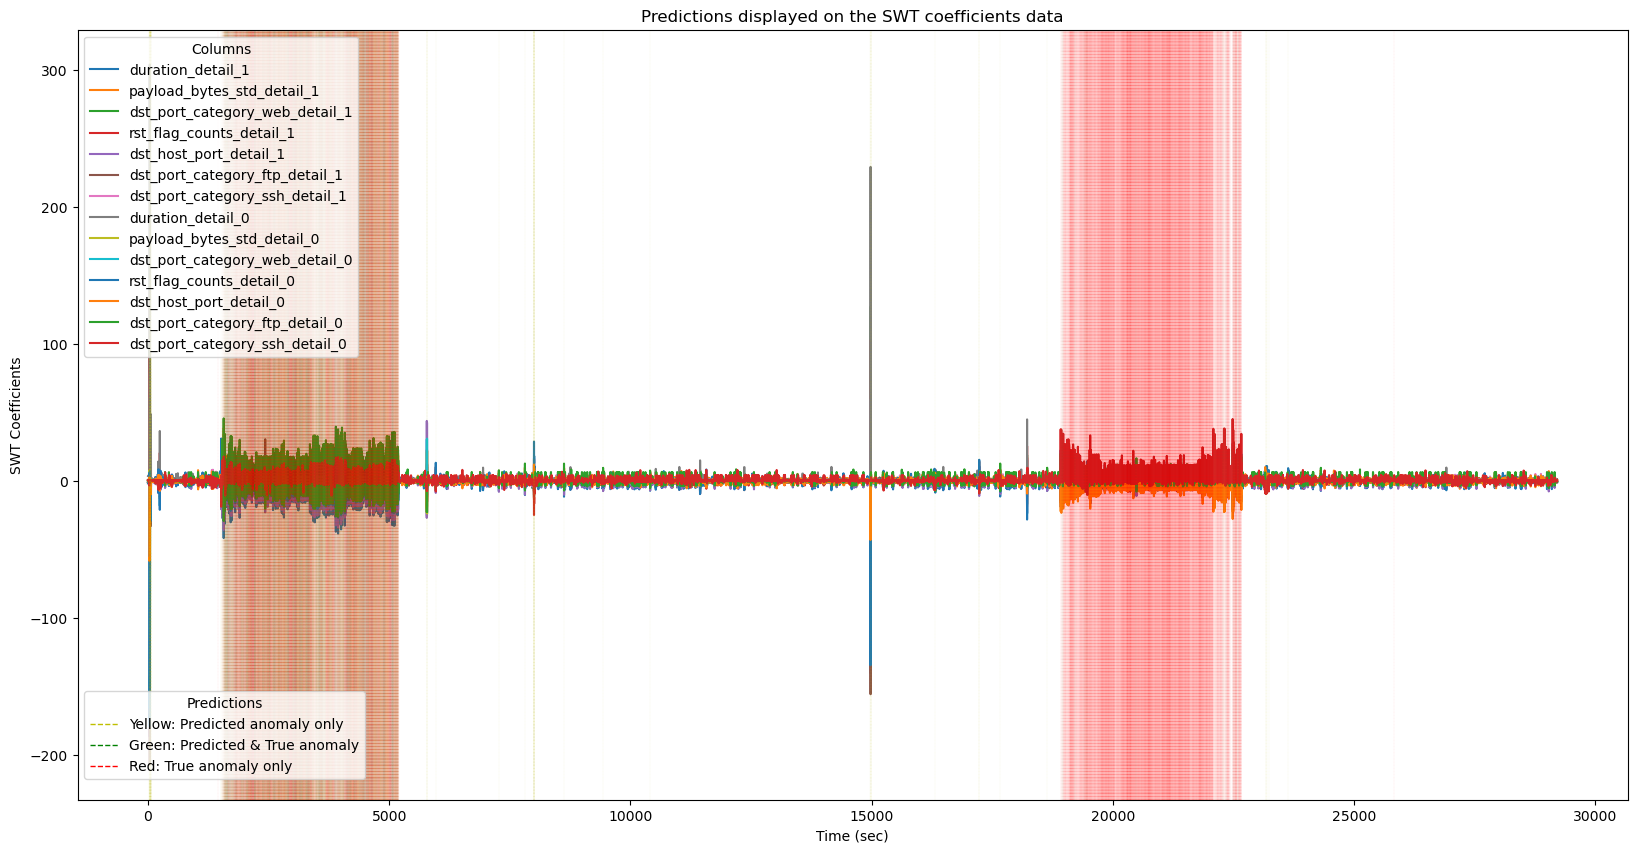

In [2368]:
plot_predictions(y_true, y_pred, X_tuesday_swt, hlinewidth=0.2, hlinealpha=0.2)